# Data Analytics for Health - Task 2.1: K-means Clustering Analysis

## Overview
This notebook performs K-means clustering analysis on the prepared patient profile:
- 2.1.1: Identification of the best value of k
- 2.1.2: Characterization of the obtained clusters (centroid analysis and distribution comparison)
- 2.1.3: Evaluation of the clustering results

## Objectives
- Determine optimal number of clusters using elbow method, silhouette analysis, etc.
- Analyze cluster characteristics through centroids and variable distributions
- Evaluate clustering quality using appropriate metrics

---


In [235]:
#%pip install umap-learn

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set up file paths
notebook_dir = Path.cwd().resolve()
data_path = (notebook_dir / '..' /  'Data').resolve()
plots_dir = (notebook_dir / '..' / 'plots').resolve()
plots_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Data path: {data_path}")
print(f"Plots directory: {plots_dir}")

# Quick listing
csv_files = sorted(data_path.glob('*.csv'))
for f in csv_files:
    print(f.name)


Libraries imported successfully
Data path: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\Data
Plots directory: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\plots
1.1.2_merged_dataset_option_a_subject_id.csv
1.1.2_merged_dataset_option_b_subject_hadm_id.csv
1.2.1_final_patient_profile.csv
1.2.1_prepared_patient_profile.csv
1.2.2_prepared_patient_profile.csv
1.2.3_final_patient_profile.csv
1.2_admission_time_features.csv
1.2_subject_time_features.csv
2.1_kmeans_clustered_data.csv
2.2_dbscan_clustered_data.csv
2.3_hierarchical_clustered_data.csv
3.1_time_series_features.csv
3.1_time_series_paa_summary.csv
heart_diagnoses_1.csv
microbiology_events_codes_3.csv
patient_profile_clustering_biological.csv
patient_profile_final_large.csv
patient_profile_master_large.csv
patient_profile_small.csv
procedure_code_4.csv


## 1. Load Prepared Patient Profile


In [10]:
# Load prepared patient profile 
df = pd.read_csv(data_path / 'patient_profile_clustering_biological.csv')

print(f"Loaded patient profile: {df.shape[0]:,} subjects × {df.shape[1]} features")
print(f"\nColumns: {df.columns.tolist()}")

# Get numeric features (excluding subject_id and categorical variables)
numeric_features = [col for col in df.columns if col != 'subject_id' and col != 'hadm_id' and df[col].dtype in [np.float64, np.int64]]
print(f"\nNumeric features for clustering: {len(numeric_features)}")
print(f"Features: {numeric_features}")

Loaded patient profile: 4,864 subjects × 12 features

Columns: ['subject_id', 'hadm_id', 'doc_complexity_index', 'cardiac_comorbidity_score', 'num_labs', 'micro_resistance_score', 'procedure_density', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index']

Numeric features for clustering: 10
Features: ['doc_complexity_index', 'cardiac_comorbidity_score', 'num_labs', 'micro_resistance_score', 'procedure_density', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index']


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       4864 non-null   int64  
 1   hadm_id                          4864 non-null   int64  
 2   doc_complexity_index             4864 non-null   float64
 3   cardiac_comorbidity_score        4864 non-null   float64
 4   num_labs                         4864 non-null   float64
 5   micro_resistance_score           4864 non-null   float64
 6   procedure_density                4864 non-null   float64
 7   metabolic_stress_index           4864 non-null   float64
 8   oxygenation_dysfunction_index    4864 non-null   float64
 9   inflammation_liver_stress_index  4864 non-null   float64
 10  hematologic_stability_score      4864 non-null   float64
 11  renal_failure_index              4864 non-null   float64
dtypes: float64(10), int6

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,4864.0,1.510717e+07,2.938761e+06,1.000098e+07,1.252385e+07,1.507553e+07,1.764939e+07,1.999860e+07
hadm_id,4864.0,2.501745e+07,2.873736e+06,2.000446e+07,2.260252e+07,2.503238e+07,2.746833e+07,2.999967e+07
doc_complexity_index,4864.0,2.230601e+01,1.271144e+00,1.722996e+01,2.148126e+01,2.230973e+01,2.317492e+01,2.765688e+01
cardiac_comorbidity_score,4864.0,8.022204e-01,3.983660e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
num_labs,4864.0,2.400483e+02,5.129063e+02,0.000000e+00,7.900000e+01,1.355000e+02,2.590000e+02,2.258000e+04
micro_resistance_score,4864.0,1.506167e-02,8.038811e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.005899e+00
procedure_density,4864.0,2.185285e+00,2.385387e+00,0.000000e+00,0.000000e+00,1.285714e+00,3.000000e+00,1.400000e+01
metabolic_stress_index,4864.0,5.700035e-01,2.882488e+00,-3.656627e+00,-7.048193e-01,1.058969e-01,1.170827e+00,1.019930e+02
oxygenation_dysfunction_index,4864.0,-4.745340e-02,1.361328e+00,-4.405457e+01,-3.422266e-01,7.369086e-03,7.042755e-01,5.850936e+00
inflammation_liver_stress_index,4864.0,9.757988e-03,1.639752e-01,-5.371486e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.420683e+00


In [13]:
# Get numeric features (excluding subject_id and categorical variables)
numeric_features = [col for col in df.columns if col != 'subject_id' and col != 'hadm_id' and df[col].dtype in [np.float64, np.int64]]
print(f"\nNumeric features for clustering: {len(numeric_features)}")
print(f"Features: {numeric_features}")


Numeric features for clustering: 10
Features: ['doc_complexity_index', 'cardiac_comorbidity_score', 'num_labs', 'micro_resistance_score', 'procedure_density', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index']


In [14]:
# maunally decrease featureset
#numeric_features = [c for c in numeric_features if c not in ['is_dead',  'fluid_diversity', 'max_blood_sodium', 'num_intermediate', 'susceptible_ratio', 'abnormal_ratio', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'micro_qc_warn' , 'micro_qc_warn']]

In [15]:
X = df[numeric_features].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   doc_complexity_index             4864 non-null   float64
 1   cardiac_comorbidity_score        4864 non-null   float64
 2   num_labs                         4864 non-null   float64
 3   micro_resistance_score           4864 non-null   float64
 4   procedure_density                4864 non-null   float64
 5   metabolic_stress_index           4864 non-null   float64
 6   oxygenation_dysfunction_index    4864 non-null   float64
 7   inflammation_liver_stress_index  4864 non-null   float64
 8   hematologic_stability_score      4864 non-null   float64
 9   renal_failure_index              4864 non-null   float64
dtypes: float64(10)
memory usage: 380.1 KB


In [16]:
# Create composite unique record id (subject_id + hadm_id) for mapping back results
df['record_id'] = df['subject_id'].astype(str) + '_' + df['hadm_id'].astype(str)
record_ids = df['record_id'].copy()

# Handle any remaining NaN values: NOTE is_Dead, abnormal_rat, qc_fail_ratio have some NaNs
print(f"\nNaN values before handling: {X.isna().sum().sum()}")
X = X.fillna(X.mean())  # Fill with mean or use appropriate strategy
print(f"NaN values after handling: {X.isna().sum().sum()}")

# Standardize features
#scaler = StandardScaler()  
scaler = RobustScaler()  
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features, index=X.index)

print(f"\nData prepared for clustering: {X_scaled_df.shape}")


NaN values before handling: 0
NaN values after handling: 0

Data prepared for clustering: (4864, 10)


## 2.1.1 Identification of the Best Value of k


In [17]:
# Test different values of k
k_range = range(2, 11)  # Test k from 2 to 10
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("Testing different values of k...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}, "
          f"DB={davies_bouldin_scores[-1]:.3f}, CH={calinski_harabasz_scores[-1]:.2f}")

# Store results
k_evaluation = pd.DataFrame({
    'k': list(k_range),
    'inertia': inertias,
    'silhouette': silhouette_scores,
    'davies_bouldin': davies_bouldin_scores,
    'calinski_harabasz': calinski_harabasz_scores
})


Testing different values of k...
k=2: Inertia=71924.82, Silhouette=0.879, DB=0.650, CH=1228.24
k=3: Inertia=56482.87, Silhouette=0.567, DB=1.078, CH=1446.33
k=4: Inertia=48760.88, Silhouette=0.557, DB=1.015, CH=1373.24
k=5: Inertia=43045.18, Silhouette=0.425, DB=0.933, CH=1327.75
k=6: Inertia=39351.36, Silhouette=0.567, DB=0.788, CH=1252.87
k=7: Inertia=35345.60, Silhouette=0.266, DB=1.053, CH=1253.90
k=8: Inertia=32302.82, Silhouette=0.266, DB=0.962, CH=1241.10
k=9: Inertia=28172.52, Silhouette=0.262, DB=0.877, CH=1333.88
k=10: Inertia=26673.82, Silhouette=0.187, DB=0.970, CH=1282.34


### Understanding Silhouette Plots

**What is a Silhouette Plot?**
A silhouette plot visualizes how well each data point fits into its assigned cluster. The silhouette coefficient ranges from **-1 to +1**:
- **+1**: Point is well-matched to its cluster and poorly matched to neighboring clusters (ideal)
- **0**: Point is on the boundary between two clusters (ambiguous)
- **-1**: Point is poorly matched to its cluster and better matched to a neighboring cluster (misclassified)

**What to Look For:**

1. **Average Silhouette Score (Red Dashed Line)**
   - Higher is better (closer to +1)
   - Values > 0.5 indicate good clustering structure
   - Values 0.3-0.5 indicate fair clustering
   - Values < 0.3 suggest poor clustering

2. **Cluster Width and Shape**
   - **Wide bars**: Most points in the cluster have high silhouette scores (good cohesion)
   - **Narrow bars**: Points have varying silhouette scores (less cohesive)
   - **Uniform width**: All clusters are similarly well-defined

3. **Cluster Heights**
   - Height represents the number of points in each cluster
   - Similar heights indicate balanced cluster sizes
   - Very different heights may indicate imbalanced clusters

4. **Negative Values**
   - Points with negative silhouette scores are closer to other clusters than their own
   - Many negative values suggest poor cluster separation
   - Ideally, all bars should be to the right of 0

5. **Comparing Different k Values**
   - Choose the k with the highest average silhouette score
   - Prefer k values where all clusters have mostly positive scores
   - Avoid k values with many negative scores or very low averages


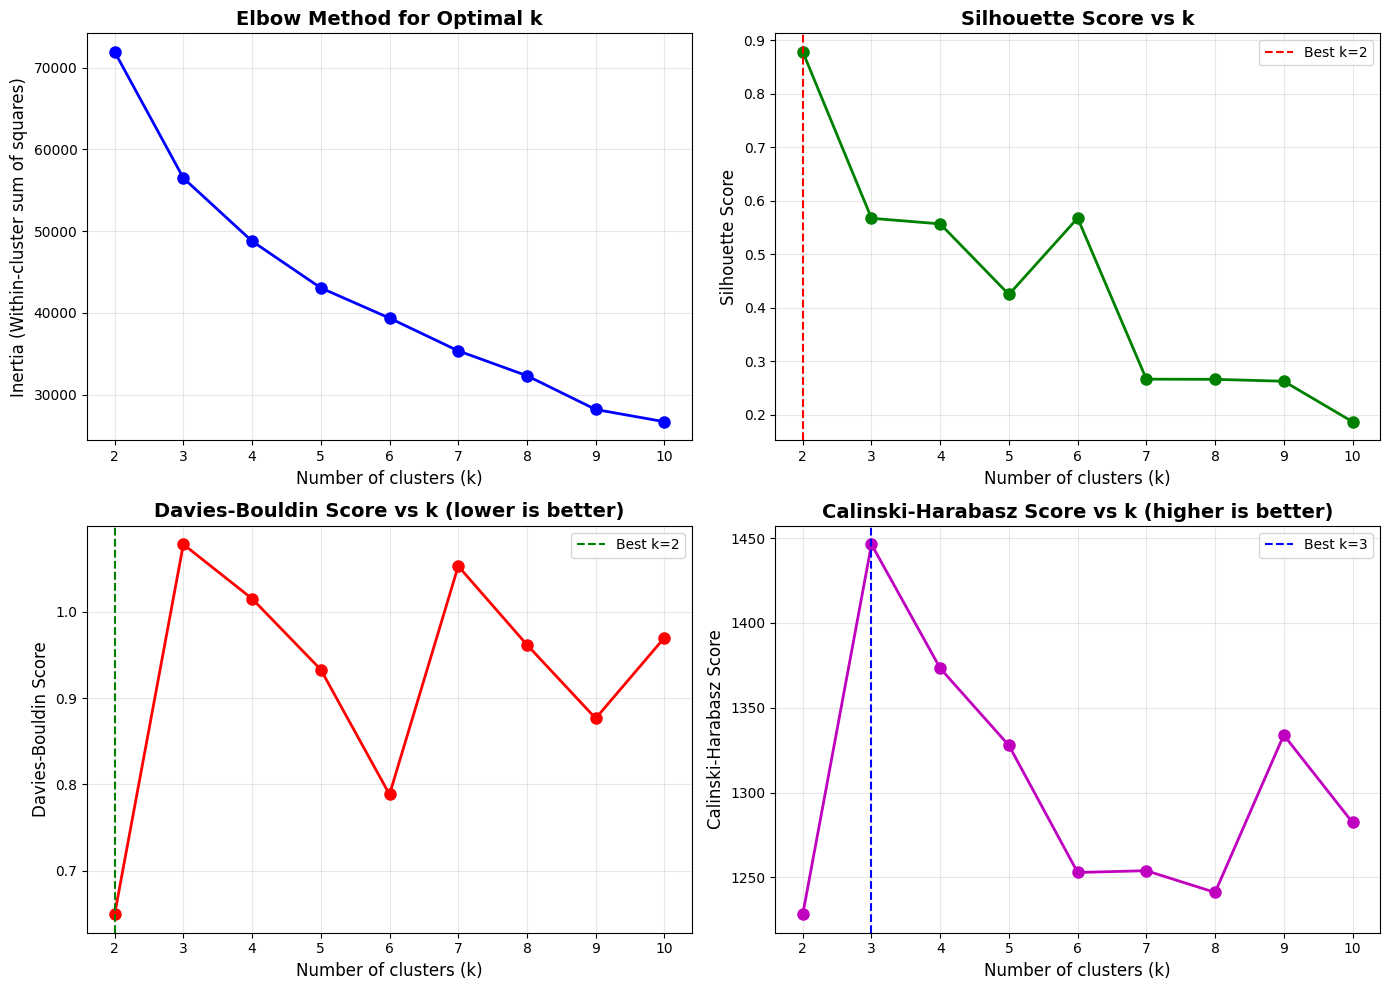


Best k based on Silhouette Score: 2
Best k based on Davies-Bouldin Score: 2
Best k based on Calinski-Harabasz Score: 3


In [18]:
# Visualize elbow method and evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow method
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0, 0].set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score vs k', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
best_k_sil = k_range[np.argmax(silhouette_scores)]
axes[0, 1].axvline(x=best_k_sil, color='r', linestyle='--', label=f'Best k={best_k_sil}')
axes[0, 1].legend()

# Davies-Bouldin score (lower is better)
axes[1, 0].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Score vs k (lower is better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
best_k_db = k_range[np.argmin(davies_bouldin_scores)]
axes[1, 0].axvline(x=best_k_db, color='g', linestyle='--', label=f'Best k={best_k_db}')
axes[1, 0].legend()

# Calinski-Harabasz score (higher is better)
axes[1, 1].plot(k_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Score vs k (higher is better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
best_k_ch = k_range[np.argmax(calinski_harabasz_scores)]
axes[1, 1].axvline(x=best_k_ch, color='b', linestyle='--', label=f'Best k={best_k_ch}')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(plots_dir / '2.1.1_k_selection_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest k based on Silhouette Score: {best_k_sil}")
print(f"Best k based on Davies-Bouldin Score: {best_k_db}")
print(f"Best k based on Calinski-Harabasz Score: {best_k_ch}")


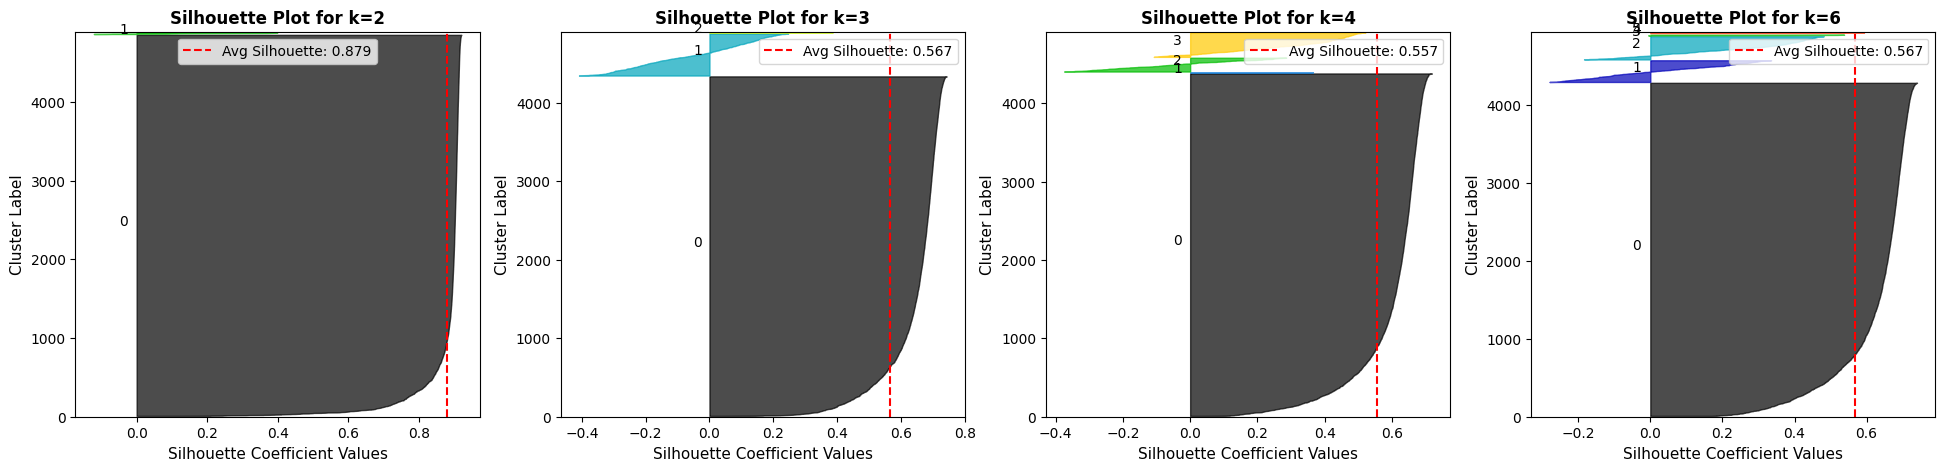

In [22]:
# Silhouette analysis for selected k values (fixed to handle single-axis and typing issues)
selected_k_values = [best_k_sil, 3, 4, 6]
if len(set(selected_k_values)) < len(selected_k_values):
    selected_k_values = list(set(selected_k_values))

# Defensive: ensure we have at least one k
if len(selected_k_values) == 0:
    selected_k_values = [best_k_sil]

fig, axes = plt.subplots(1, len(selected_k_values), figsize=(6 * len(selected_k_values), 5))
# Normalize axes to a list so axes[idx] always works
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten().tolist()
else:
    axes_list = [axes]

for idx, k in enumerate(selected_k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    labels = np.asarray(labels)  # ensure numpy array

    silhouette_avg = float(silhouette_score(X_scaled, labels))
    sample_silhouette_values = np.asarray(silhouette_samples(X_scaled, labels))

    y_lower = 10
    n_samples = X_scaled.shape[0]
    cmap = plt.cm.get_cmap('nipy_spectral')  # robust colormap access

    ax = axes_list[idx]
    for i in range(k):
        mask = (labels == i)
        ith_cluster_silhouette_values = sample_silhouette_values[mask]
        if ith_cluster_silhouette_values.size == 0:
            continue

        ith_sorted = np.sort(ith_cluster_silhouette_values)
        size_cluster_i = ith_sorted.size
        y_upper = y_lower + size_cluster_i

        color = cmap(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_sorted,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.axvline(x=silhouette_avg, color="red", linestyle="--",
               label=f'Avg Silhouette: {silhouette_avg:.3f}')
    ax.set_xlabel('Silhouette Coefficient Values', fontsize=11)
    ax.set_ylabel('Cluster Label', fontsize=11)
    ax.set_title(f'Silhouette Plot for k={k}', fontsize=12, fontweight='bold')
    ax.set_ylim([0, n_samples + (k + 1) * 10])
    ax.legend()

#plt.tight_layout()
plt.savefig(plots_dir / '2.1.1_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

The silhouette coefficient ranges from **-1 to +1**:
- **+1**: Point is well-matched to its cluster and poorly matched to neighboring clusters (ideal)
- **0**: Point is on the boundary between two clusters (ambiguous)
- **-1**: Point is poorly matched to its cluster and better matched to a neighboring cluster (misclassified)

**What to Look For:**

1. **Average Silhouette Score (Red Dashed Line)**
   - Higher is better (closer to +1)
   - Values > 0.5 indicate good clustering structure
   - Values 0.3-0.5 indicate fair clustering
   - Values < 0.3 suggest poor clustering

2. **Cluster Width and Shape**
   - **Wide bars**: Most points in the cluster have high silhouette scores (good cohesion)
   - **Narrow bars**: Points have varying silhouette scores (less cohesive)
   - **Uniform width**: All clusters are similarly well-defined

3. **Cluster Heights**
   - Height represents the number of points in each cluster
   - Similar heights indicate balanced cluster sizes
   - Very different heights may indicate imbalanced clusters

4. **Negative Values**
   - Points with negative silhouette scores are closer to other clusters than their own
   - Many negative values suggest poor cluster separation
   - Ideally, all bars should be to the right of 0

5. **Comparing Different k Values**
   - Choose the k with the highest average silhouette score
   - Prefer k values where all clusters have mostly positive scores
   - Avoid k values with many negative scores or very low averages


## 2.1.2 Characterization of the Obtained Clusters

### Select optimal k and perform final clustering


In [20]:
selected_k_values

[2, 3, 6]

In [23]:
optimal_k = best_k_db

# TODO
# Manually override to try different Ks
optimal_k = 6
# TODO

print(f"Selected optimal k: {optimal_k}")
print(f"Note: Chosen for patient profiling purposes (more nuanced patient stereotypes)")
print(f"  - Metrics-based best k (silhouette): {best_k_sil}")
print(f"  - Metrics-based best k (Davies-Bouldin): {best_k_db}")
print(f"  - Metrics-based best k (Calinski-Harabasz): {best_k_ch}")

# Perform final clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

print(f"\nCluster distribution:")
print(df_clustered['cluster'].value_counts().sort_index())

# Save clustered data
df_clustered.to_csv(data_path / '2.1_kmeans_clustered_data.csv', index=False)
print(f"\nClustered data saved to: {data_path / '2.1_kmeans_clustered_data.csv'}")


Selected optimal k: 6
Note: Chosen for patient profiling purposes (more nuanced patient stereotypes)
  - Metrics-based best k (silhouette): 2
  - Metrics-based best k (Davies-Bouldin): 2
  - Metrics-based best k (Calinski-Harabasz): 3

Cluster distribution:
cluster
0    4270
1     279
2     298
3       9
4       1
5       7
Name: count, dtype: int64

Clustered data saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\Data\2.1_kmeans_clustered_data.csv


### How to Interpret the Cluster Centroids Comparison Plot

**What are Centroids?**
- Centroids represent the "average" or "typical" patient profile for each cluster
- Each centroid value shows the mean feature value for all patients in that cluster
- Values are in the **original scale** (not standardized), so they're interpretable in real-world units

**Reading the Plot:**

1. **X-axis (Features)**: Each bar position represents a different feature (e.g., n_lab_events, age, max_glucose)

2. **Y-axis (Feature Values)**: The height of each bar shows the centroid value for that feature
   - Higher bars = cluster has higher average values for that feature
   - Lower bars = cluster has lower average values for that feature
   - Bars near zero = cluster has values close to the overall dataset mean

3. **Colors (Clusters)**: Each color represents a different cluster
   - Compare how different clusters differ across features
   - Look for patterns: which clusters are similar? Which are distinct?

**What to Look For:**

1. **Distinctive Features per Cluster**
   - Find features where one cluster's bar is much higher/lower than others
   - These features help characterize and distinguish that cluster
   - Example: If Cluster 6 has a very high bar for "max_glucose", it represents patients with many diagnoses

2. **Cluster Similarities**
   - Clusters with similar bar patterns across features are similar patient types
   - Clusters with very different patterns represent distinct patient profiles

3. **Feature Patterns**
   - Look for features where clusters show clear separation (good for distinguishing clusters)
   - Features where all clusters are similar indicate less discriminatory power

4. **Clinical Interpretation**
   - Translate centroid values into patient characteristics:
     - High max_glucose → diabetic/metabolic issues
     - High n_lab_events → more intensive monitoring
     - High abnormal_ratio → more abnormal test results
     - High age → older patient population

**Example Interpretation:**
- If Cluster 4 has high bars for "n_lab_events", "n_micro_exam", and "abnormal_ratio", it might represent: *"Patients with extensive testing and many abnormal results - possibly complex cases requiring intensive monitoring"*
- If Cluster 0 has low bars across most features, it might represent: *"Relatively healthy patients with minimal testing and normal results"*


### Analysis of Cluster Centroids


Cluster Centroids (original scale):
           doc_complexity_index  cardiac_comorbidity_score  num_labs  \
Cluster 0                 22.23                       0.79    164.19   
Cluster 1                 22.99                       0.85   1089.42   
Cluster 2                 22.66                       0.87    279.01   
Cluster 3                 22.89                       1.00    928.78   
Cluster 4                 21.95                       0.00  22580.00   
Cluster 5                 23.63                       1.00   6926.14   

           micro_resistance_score  procedure_density  metabolic_stress_index  \
Cluster 0                    0.01               2.22                    0.16   
Cluster 1                    0.07               1.69                    3.33   
Cluster 2                    0.03               2.22                    3.56   
Cluster 3                    0.04               0.66                    2.13   
Cluster 4                    0.00               1.47       

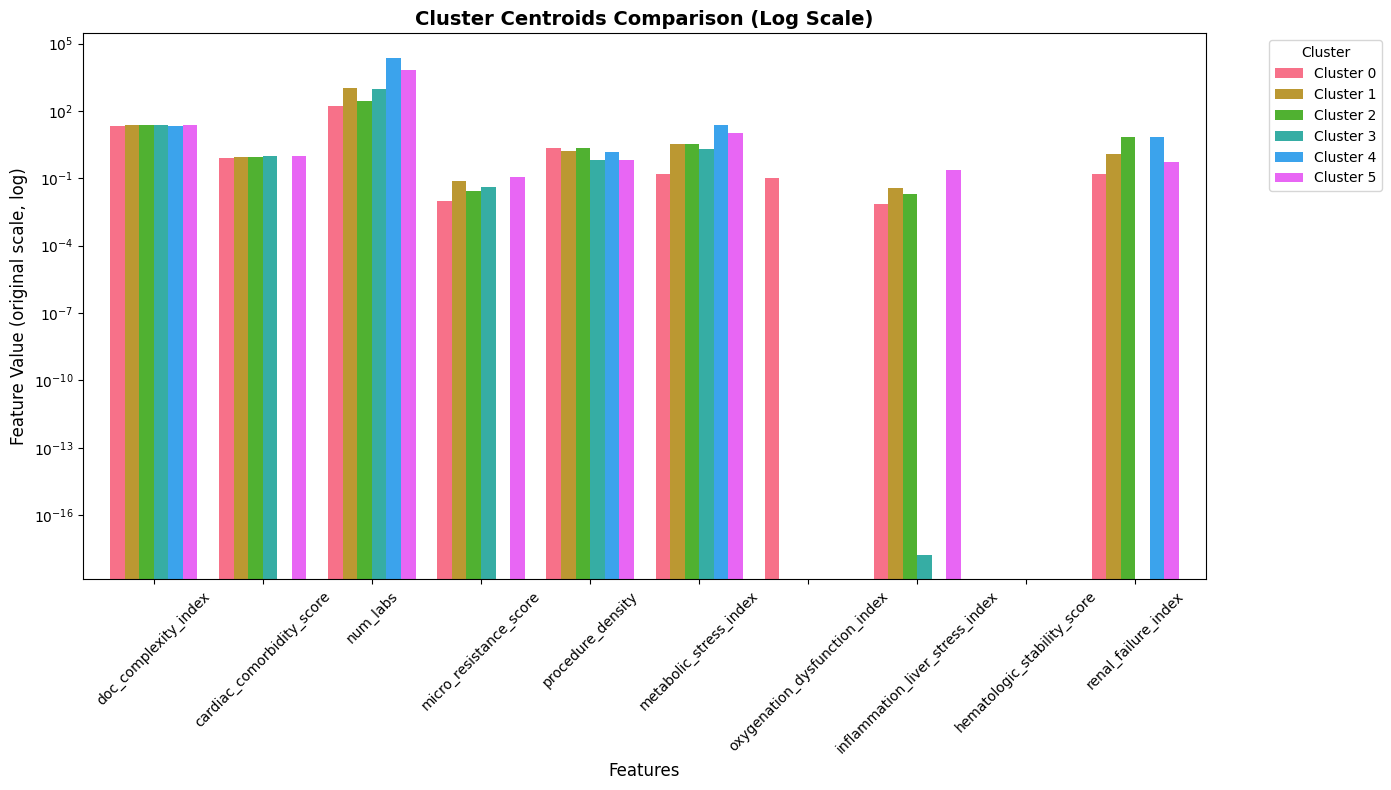

In [24]:
# Get centroids (in scaled space) and transform back to original scale
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Create dataframe with centroids
centroids_df = pd.DataFrame(centroids_original, columns=numeric_features)
centroids_df.index.name = 'cluster'
centroids_df.index = [f'Cluster {i}' for i in range(optimal_k)]

print("Cluster Centroids (original scale):")
print(centroids_df.round(2))

# Visualize centroids
fig, ax = plt.subplots(figsize=(14, 8))
centroids_df.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Feature Value (original scale, log)', fontsize=12)
ax.set_yscale('log')
ax.set_title('Cluster Centroids Comparison (Log Scale)', fontsize=14, fontweight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(plots_dir / '2.1.2_centroids_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### Comparison of Variable Distributions: Within Clusters vs Whole Dataset


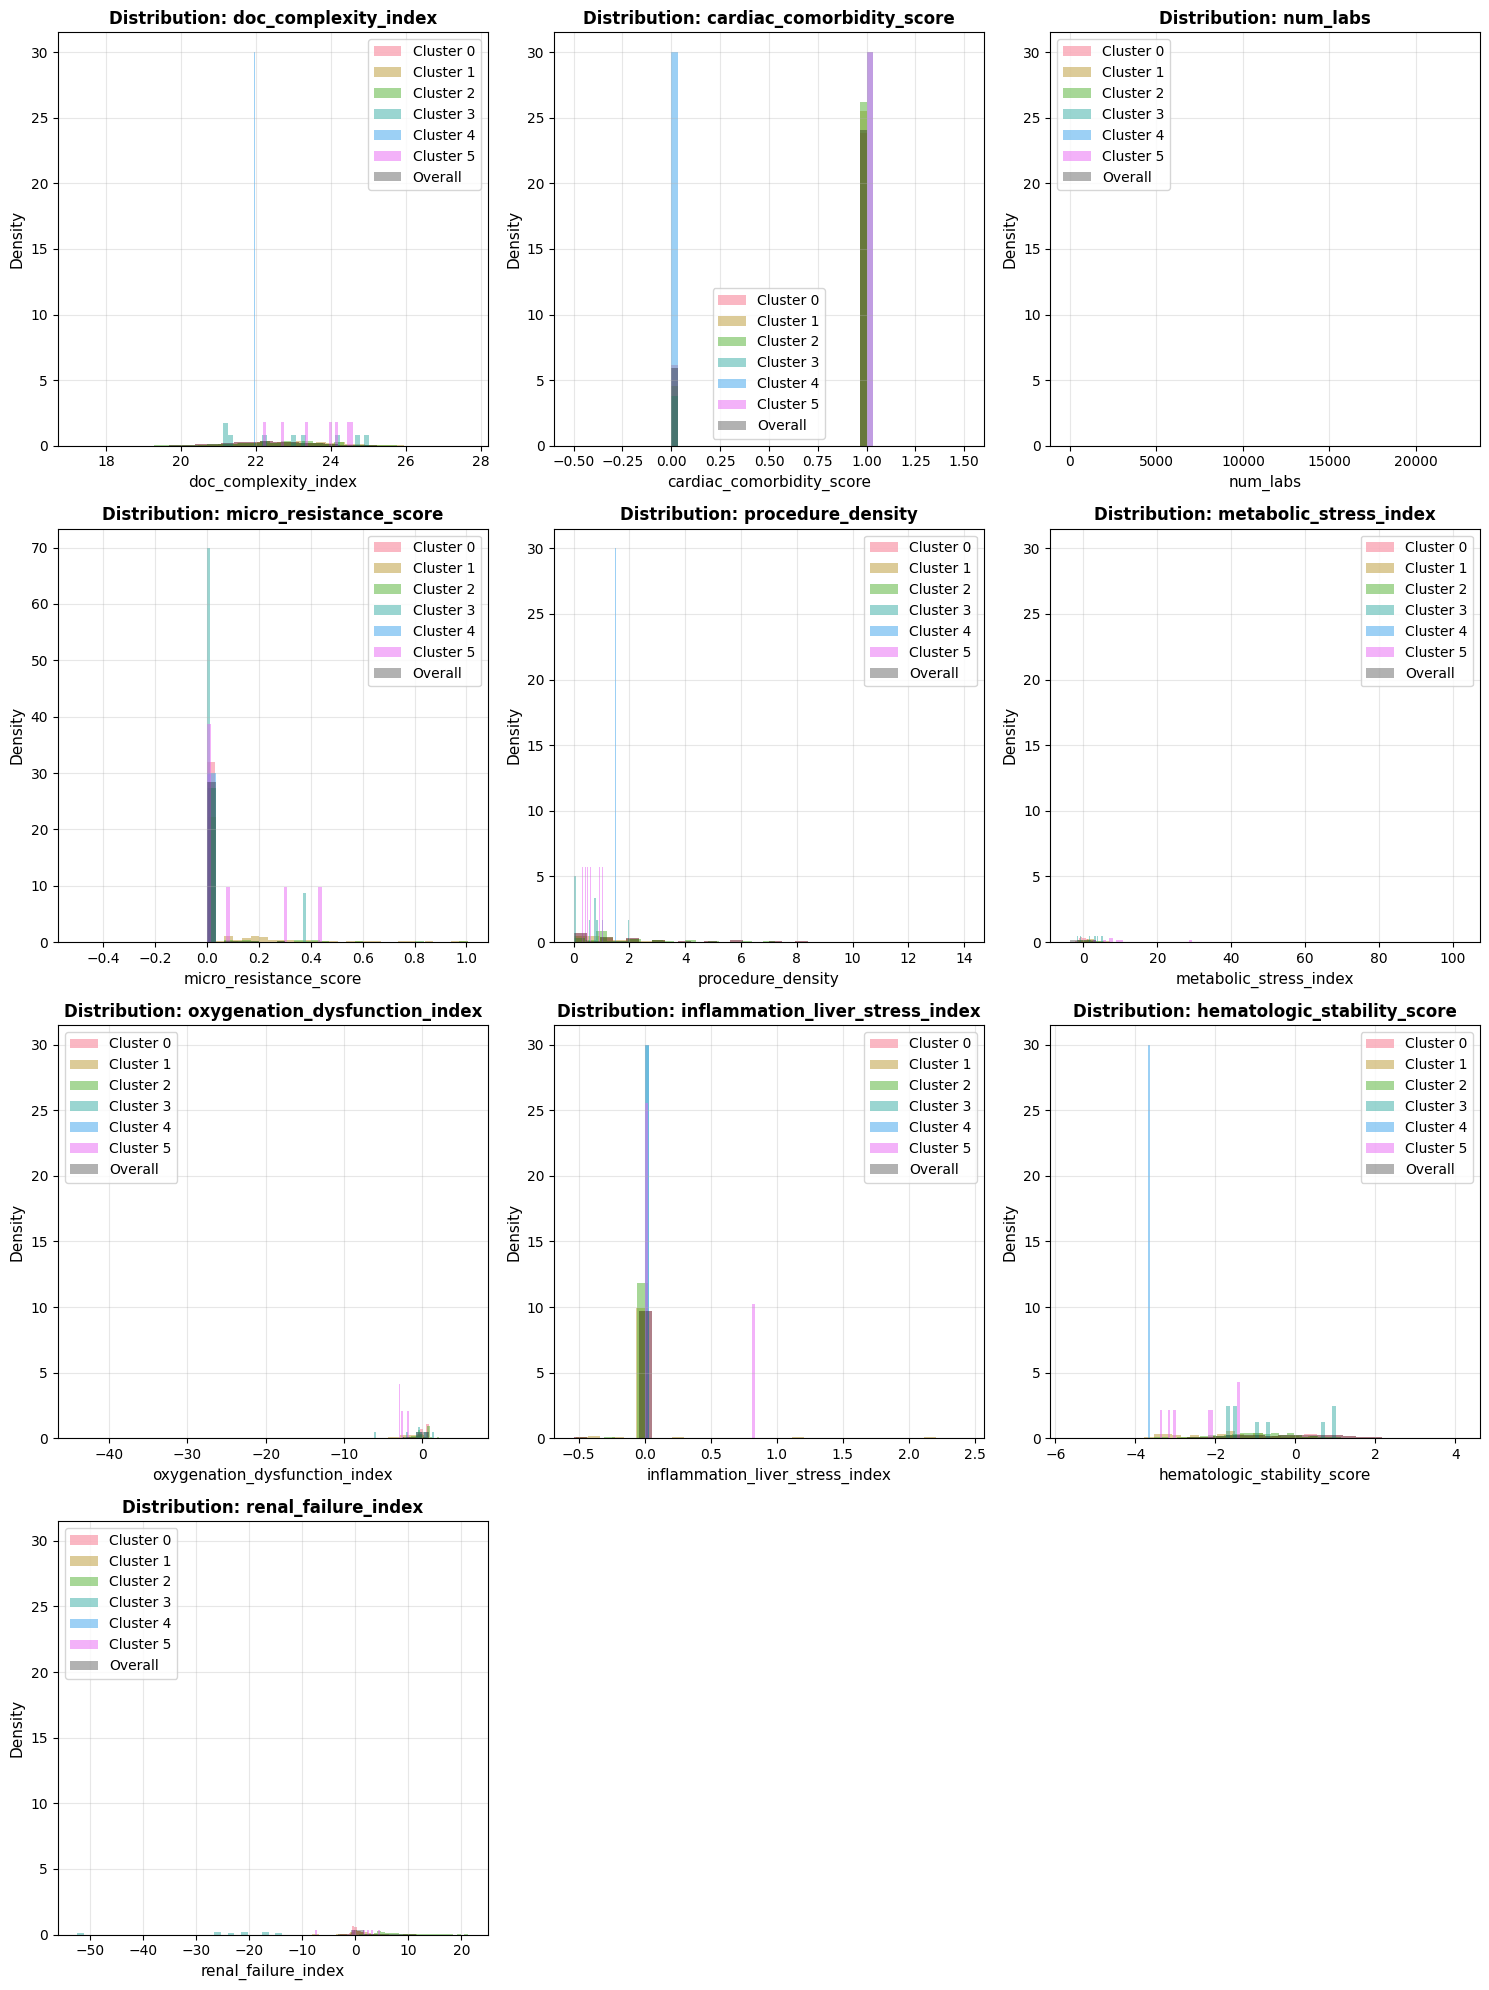

In [25]:
# Compare distributions for key features
key_features = numeric_features

n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Plot distribution for each cluster
    for cluster_id in range(optimal_k):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id][feature]
        ax.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster_id}', bins=30, density=True)
    
    # Plot overall distribution
    ax.hist(df_clustered[feature], alpha=0.3, color='black', 
           label='Overall', bins=30, density=True, linestyle='--', linewidth=2)
    
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Distribution: {feature}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(plots_dir / '2.1.2_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


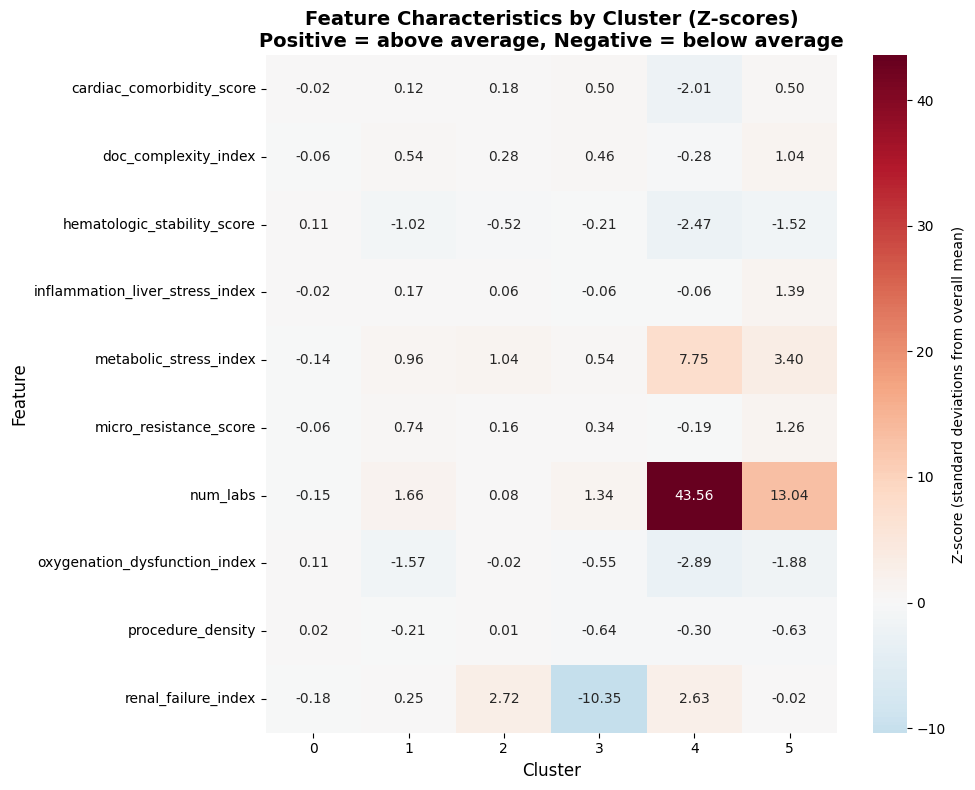


Cluster Characteristics Summary:
cluster
0    [{'feature': 'oxygenation_dysfunction_index', ...
1    [{'feature': 'num_labs', 'z_score': 1.65598936...
2    [{'feature': 'renal_failure_index', 'z_score':...
3    [{'feature': 'num_labs', 'z_score': 1.34279769...
4    [{'feature': 'num_labs', 'z_score': 43.5556154...
5    [{'feature': 'num_labs', 'z_score': 13.0357024...
dtype: object


In [26]:
# Statistical comparison: mean values per cluster vs overall mean
comparison_stats = []

for feature in numeric_features:
    overall_mean = df_clustered[feature].mean()
    overall_std = df_clustered[feature].std()
    
    for cluster_id in range(optimal_k):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id][feature]
        cluster_mean = cluster_data.mean()
        cluster_std = cluster_data.std()
        
        # Z-score: how many standard deviations away from overall mean
        z_score = (cluster_mean - overall_mean) / overall_std if overall_std > 0 else 0
        
        comparison_stats.append({
            'feature': feature,
            'cluster': cluster_id,
            'cluster_mean': cluster_mean,
            'cluster_std': cluster_std,
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'difference': cluster_mean - overall_mean,
            'z_score': z_score
        })

comparison_df = pd.DataFrame(comparison_stats)

# Create heatmap of z-scores
pivot_z = comparison_df.pivot(index='feature', columns='cluster', values='z_score')

plt.figure(figsize=(10, max(8, len(numeric_features)*0.5)))
sns.heatmap(pivot_z, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
           cbar_kws={'label': 'Z-score (standard deviations from overall mean)'})
plt.title('Feature Characteristics by Cluster (Z-scores)\nPositive = above average, Negative = below average', 
         fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(plots_dir / '2.1.2_cluster_characteristics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCluster Characteristics Summary:")
print(comparison_df.groupby('cluster')[['feature', 'z_score']].apply(
    lambda x: x.nlargest(3, 'z_score')[['feature', 'z_score']].to_dict('records')
))


### 2D Visualization using PCA


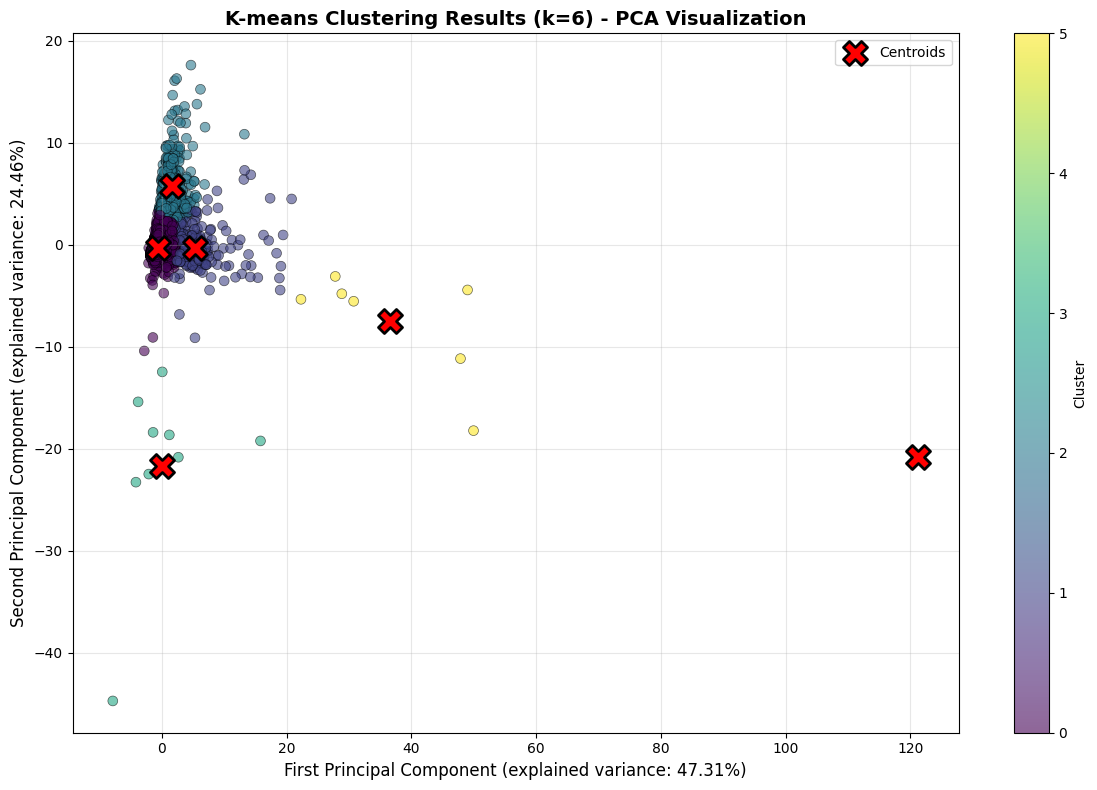

PCA explained variance ratio: [0.47306195 0.24461661]
Total explained variance: 71.77%


In [27]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                    cmap='viridis', alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

# Plot centroids in PCA space
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
          c='red', marker='X', s=300, edgecolors='black', linewidth=2, 
          label='Centroids', zorder=10)

ax.set_xlabel(f'First Principal Component (explained variance: {pca.explained_variance_ratio_[0]:.2%})', 
             fontsize=12)
ax.set_ylabel(f'Second Principal Component (explained variance: {pca.explained_variance_ratio_[1]:.2%})', 
             fontsize=12)
ax.set_title(f'K-means Clustering Results (k={optimal_k}) - PCA Visualization', 
            fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.savefig(plots_dir / '2.1.2_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")


### UMAP vs PCA

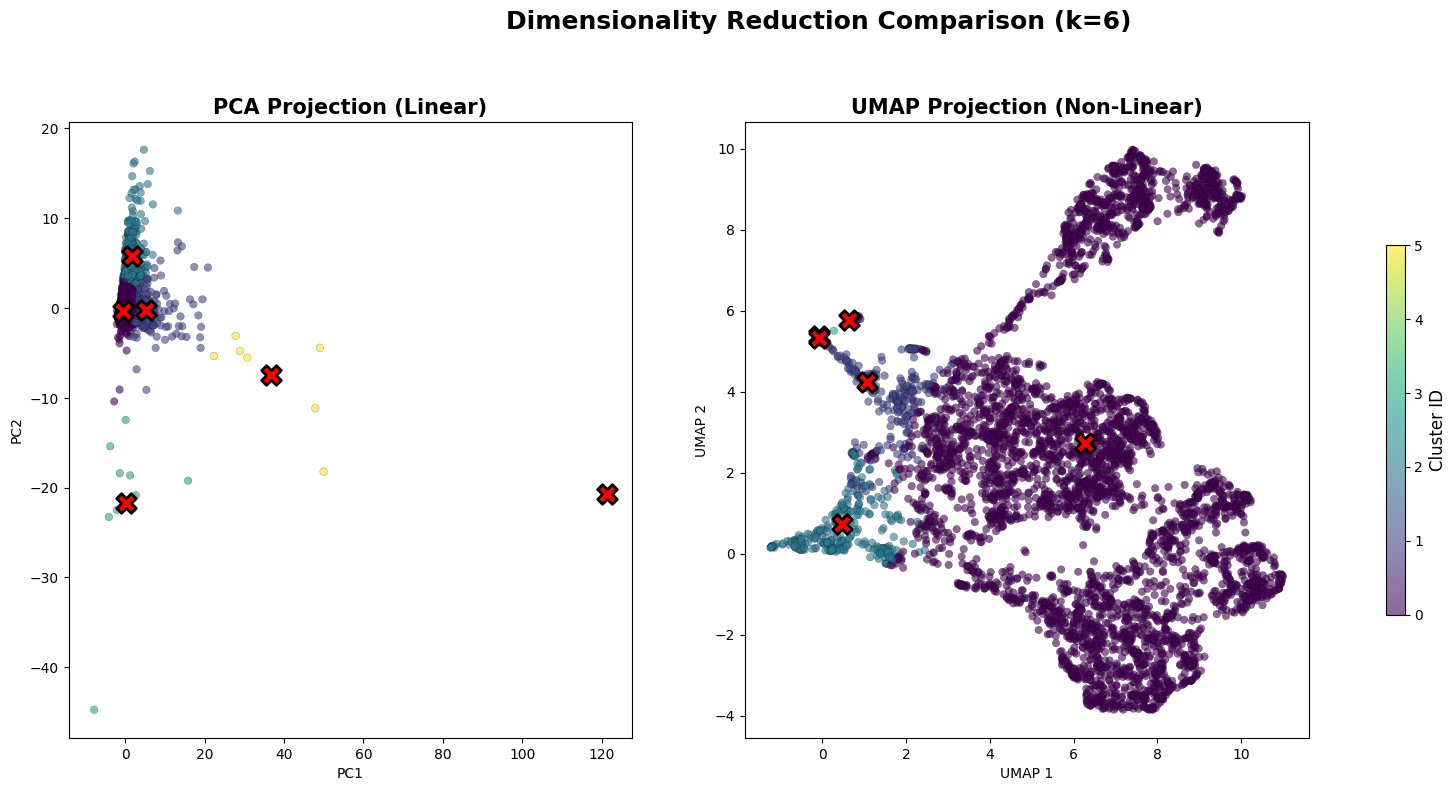

In [28]:
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize UMAP
# n_neighbors: low (5-20) focuses on local detail; high (50+) focuses on global structure
# min_dist: controls how tightly points are packed together
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 2. Re-run your PCA for the comparison
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 3. Create Side-by-Side Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot PCA
# Plot centroids in PCA space
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
ax1.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
          c='red', marker='X', s=200, edgecolors='black', linewidth=2, 
          label='Centroids', zorder=10)

scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                      cmap='viridis', alpha=0.6, s=30, edgecolors='k', linewidth=0.2)
ax1.set_title('PCA Projection (Linear)', fontsize=15, fontweight='bold')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# Plot UMAP
# plot centroids in UMAP space
centroids_umap = reducer.transform(kmeans_final.cluster_centers_)
ax2.scatter(centroids_umap[:, 0], centroids_umap[:, 1], 
          c='red', marker='X', s=200, edgecolors='black', linewidth=2, 
          label='Centroids', zorder=10)

scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, 
                      cmap='viridis', alpha=0.6, s=30, edgecolors='k', linewidth=0.2)
ax2.set_title('UMAP Projection (Non-Linear)', fontsize=15, fontweight='bold')
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')

# Add a shared colorbar
cbar = fig.colorbar(scatter2, ax=[ax1, ax2], location='right', shrink=0.6)
cbar.set_label('Cluster ID', fontsize=12)

plt.suptitle(f'Dimensionality Reduction Comparison (k={optimal_k})', fontsize=18, fontweight='bold', y=1.02)
plt.savefig(plots_dir / '2.1.2_pca_vs_umap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Clinical outcomes

In [29]:
# Create a quick summary table of clinical outcomes
outcome_summary = df_clustered.groupby('cluster').agg({
    #'is_dead': 'mean',
    #'history_depth': 'mean',
    'metabolic_stress_index': 'mean',
    #'age': 'mean' # only if using the narrow profile
}).round(3)

print("Clinical Outcomes by Cluster:")
print(outcome_summary)

Clinical Outcomes by Cluster:
         metabolic_stress_index
cluster                        
0                         0.156
1                         3.332
2                         3.560
3                         2.133
4                        22.900
5                        10.369


### Describe per cluster

In [30]:
# # This creates a summary table of every feature's mean, min, and max for each cluster
# cluster_summary_table = df_clustered.groupby('cluster').describe().transpose()

# means_only = df_clustered.groupby('cluster').mean()
# print(means_only)

## 2.1.3 Evaluation of the Clustering Results


In [436]:
# Compute evaluation metrics
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels)
inertia = kmeans_final.inertia_

print("="*80)
print("K-MEANS CLUSTERING EVALUATION METRICS")
print("="*80)
print(f"Number of clusters (k): {optimal_k}")
print(f"\nSilhouette Score: {silhouette_avg:.4f}")
print("  (Range: -1 to 1, higher is better)")
print(f"\nDavies-Bouldin Score: {davies_bouldin:.4f}")
print("  (Range: 0 to ∞, lower is better)")
print(f"\nCalinski-Harabasz Score: {calinski_harabasz:.4f}")
print("  (Range: 0 to ∞, higher is better)")
print(f"\nInertia (Within-cluster sum of squares): {inertia:.2f}")
print("  (Lower is better, but decreases with more clusters)")

# Create summary dataframe
evaluation_summary = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Score', 
               'Calinski-Harabasz Score', 'Inertia'],
    'Value': [silhouette_avg, davies_bouldin, calinski_harabasz, inertia],
    'Interpretation': [
        f"{'Good' if silhouette_avg > 0.5 else 'Fair' if silhouette_avg > 0.3 else 'Poor'} clustering structure",
        f"{'Good' if davies_bouldin < 1 else 'Fair' if davies_bouldin < 2 else 'Poor'} cluster separation",
        f"Higher values indicate better defined clusters",
        f"Within-cluster variance"
    ]
})

print("\n" + "="*80)
print("EVALUATION SUMMARY")
print("="*80)
print(evaluation_summary.to_string(index=False))


K-MEANS CLUSTERING EVALUATION METRICS
Number of clusters (k): 2

Silhouette Score: 0.9410
  (Range: -1 to 1, higher is better)

Davies-Bouldin Score: 0.0490
  (Range: 0 to ∞, lower is better)

Calinski-Harabasz Score: 98572.6313
  (Range: 0 to ∞, higher is better)

Inertia (Within-cluster sum of squares): 87249.65
  (Lower is better, but decreases with more clusters)

EVALUATION SUMMARY
                 Metric        Value                                 Interpretation
       Silhouette Score     0.940962                      Good clustering structure
   Davies-Bouldin Score     0.049000                        Good cluster separation
Calinski-Harabasz Score 98572.631338 Higher values indicate better defined clusters
                Inertia 87249.645727                        Within-cluster variance



CLUSTER SIZE ANALYSIS
Cluster 0: 4,864 subjects (94.2%)
Cluster 1: 302 subjects (5.8%)


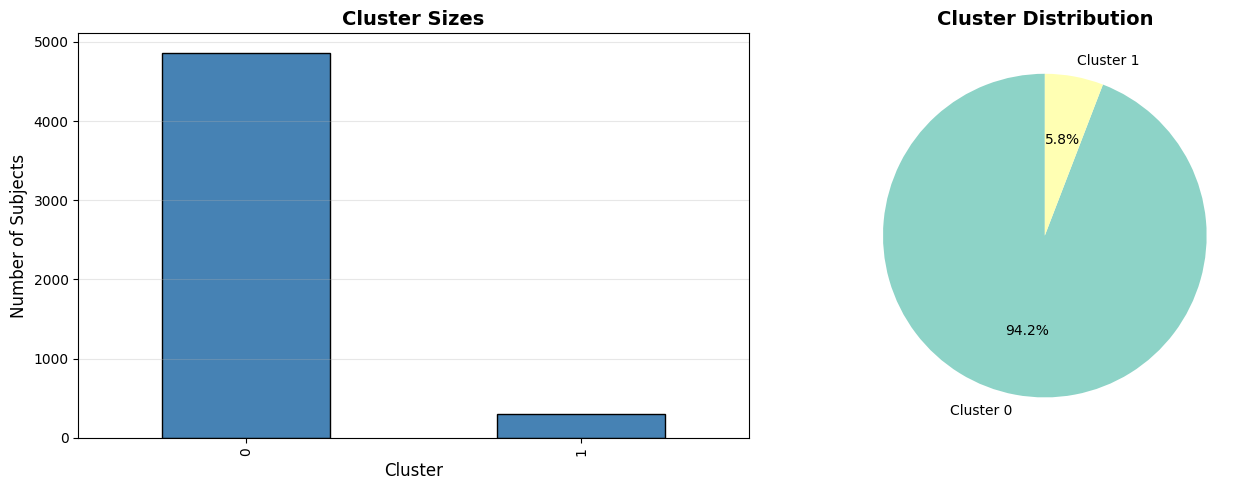

In [437]:
# Cluster size analysis
cluster_sizes = df_clustered['cluster'].value_counts().sort_index()
cluster_proportions = cluster_sizes / len(df_clustered)

print("\n" + "="*80)
print("CLUSTER SIZE ANALYSIS")
print("="*80)
for cluster_id in range(optimal_k):
    size = cluster_sizes[cluster_id]
    prop = cluster_proportions[cluster_id]
    print(f"Cluster {cluster_id}: {size:,} subjects ({prop:.1%})")

# Visualize cluster sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
cluster_sizes.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_ylabel('Number of Subjects', fontsize=12)
ax1.set_title('Cluster Sizes', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Pie chart
ax2.pie(cluster_sizes, labels=[f'Cluster {i}' for i in range(optimal_k)], 
       autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
ax2.set_title('Cluster Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(plots_dir / '2.1.3_cluster_sizes.png', dpi=300, bbox_inches='tight')
plt.show()
